In [1]:
import numpy as np
import cv2
import h5py
import os
import matplotlib.pyplot as plt
import tqdm


In [2]:
# Prepare reading datasets, metadata texts
prefix_txt = "landmarks."
prefix_img = "coarse_tilt_aligned_face."
cwd = os.getcwd()+"/"
textfiles = ['fold_0_data.txt','fold_1_data.txt','fold_2_data.txt','fold_3_data.txt','fold_4_data.txt']

# Since there are labels that do not match the classes stated, need to fix them
classes = ["(0, 2)", "(4, 6)", "(8, 12)", "(15, 20)", "(25, 32)", "(38, 43)", "(48, 53)", "(60, 100)"]
fix_dict = {'35': classes[5], '3': classes[0], '55': classes[7], '58': classes[7], 
'22': classes[3], '13': classes[2], '45': classes[5], '36': classes[5], 
'23': classes[4], '57': classes[7], '56': classes[6], '2': classes[0], 
'29': classes[4], '34': classes[4], '42': classes[5], '46': classes[6], 
'32': classes[4], '(38, 48)': classes[5], '(38, 42)': classes[5], '(8, 23)': classes[2],
 '(27, 32)': classes[4]}



In [3]:
none_count = 0
def return_five_cross_validation(textfile):
    global none_count
    # one big folder list
    folder = []
    # start processing txt
    with open(textfile) as text:
        lines = text.readlines()
    for line in lines[1:]:
        line = line.strip().split("\t")
        # real image path from folder
        img_path = line[0]+"/"+prefix_img+line[2]+"."+line[1]
        landmark_txt_path = line[0]+"/"+prefix_txt+line[2]+"."+line[1][:-3]+"txt"
        if line[3] == "None":
            none_count += 1
            continue
        else:
            folder.append([img_path]+[landmark_txt_path]+line[3:5]+[line[-2]])
            if folder[-1][2] in fix_dict:
                folder[-1][2] = fix_dict[folder[-1][2]]
    return folder


all_folders = []
for textfile in textfiles:
    folder = return_five_cross_validation(textfile)
    all_folders.append(folder)
print("A sample:", all_folders[0][0])
print("No. of Pics without Age Group Label:", none_count)



A sample: ['30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg', '30601258@N03/landmarks.1.10399646885_67c7d20df9_o.txt', '(25, 32)', 'f', '30']
No. of Pics without Age Group Label: 748


In [4]:
# Methods for processing img arrays, landmarks and one-hot generation
def read_landmark_file(filename):
    f = open(filename, 'r')
    points = []
    for line in f.readlines()[2:]:
        line = line.strip().split(",")[-2:]
        points.append(np.array(line, dtype=float).astype(int))
    f.close()
    return points

def imread(path, width, height):
    img = cv2.imread(path)
    return img

def build_one_hot(age):
    label = np.zeros(len(classes), dtype=int)
    label[classes.index(age)] = 1
    return label

def resize(img, points=None, width=224, height=224):
    # translate landmark
    resize_ratio_x = width/img.shape[1]
    resize_ratio_y = height/img.shape[0]
    for i in range(len(points)):
        points[i][0] = int(resize_ratio_x*points[i][0])
        points[i][1] = int(resize_ratio_y*points[i][1])
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
    return img, points

  0%|          | 0/4432 [00:00<?, ?it/s]

Start reading images data...


  0%|          | 4/3693 [00:00<01:53, 32.51it/s]

One folder done...


  0%|          | 4/3343 [00:00<01:30, 36.83it/s]

One folder done...


  0%|          | 5/3400 [00:00<01:14, 45.72it/s]

One folder done...


  0%|          | 4/3754 [00:00<01:34, 39.58it/s]

One folder done...


100%|██████████| 3754/3754 [01:28<00:00, 42.29it/s] 


One folder done...
All done!


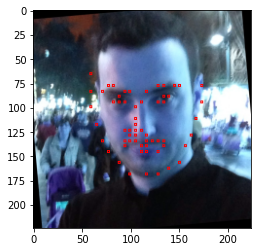

In [5]:
# image size
width, height = 224, 224

# loop for reading imgs from five folders
all_data = []
all_labels = []
all_landmark_points = []
print("Start reading images data...")
for folder in all_folders:
    data = []
    labels = []
    landmark_points = []
    for i in tqdm.tqdm(range(len(folder))):    # here using tqdm to monitor progress
        img = imread(folder[i][0], width, height)
        points = read_landmark_file(folder[i][1])
        one_hot = build_one_hot(folder[i][2])
        img, points = resize(img, points, width, height)
        data.append(img)
        labels.append(one_hot)
        landmark_points.append(points)
    all_data.append(data)
    all_labels.append(labels)
    all_landmark_points.append(landmark_points)
    print("One folder done...")
print("All done!")

img = all_data[0][15].copy()
for point in all_landmark_points[0][15]:
    cv2.rectangle(img, (point[0], point[1]),(point[0]+2, point[1]+2),(255,0,0),1)
plt.imshow(img)

#plt.subplot(131),plt.imshow(all_data[0][0]),plt.title(all_labels[0][0])
#plt.subplot(132),plt.imshow(all_data[1][0]),plt.title(all_labels[1][0])
#plt.subplot(133),plt.imshow(all_data[2][0]),plt.title(all_labels[2][0])

/home/rishi/.virtualenvs/Tensorflow-Py3/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(<matplotlib.axes._subplots.AxesSubplot at 0x7fdd708589b0>,
 Text(0.5, 1.0, '[1 0 0 0 0 0 0 0]'))

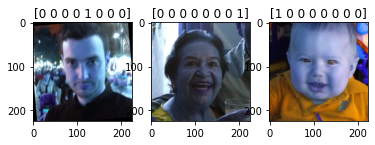

In [6]:
img = all_data[0][700].copy()
for point in all_landmark_points[0][700]:
    cv2.rectangle(img, (point[0], point[1]),(point[0]+2, point[1]+2),(255,0,0),1)
plt.imshow(img)

plt.subplot(131),plt.imshow(all_data[0][15]),plt.title(all_labels[0][15])
plt.subplot(132),plt.imshow(all_data[1][0]),plt.title(all_labels[1][0])
plt.subplot(133),plt.imshow(all_data[2][0]),plt.title(all_labels[2][0])


In [7]:


# calculation of channel-wise BGR means for five folders
b_folders = []
g_folders = []
r_folders = []
n_images_folders = []

# First we summarize rgb values
for i in tqdm.tqdm(range(0, 5)):
    b = np.zeros((height, width))
    g = np.zeros((height, width))
    r = np.zeros((height, width))
    for img in all_data[i]:
        b += img[:,:,0]
        g += img[:,:,1]
        r += img[:,:,2]
    b_folders.append(b)
    g_folders.append(g)
    r_folders.append(r)
    n_images_folders.append(len(all_data[i]))

# Then we generate BGR mean for each cross validation situation
# eg. When we validate folder 1, RGB mean will be generated from folder 2~5
bgr_means = []
for i in range(0, 5):
    folders = [0,1,2,3,4]
    folders.remove(i)
    b = np.zeros((height, width))
    g = np.zeros((height, width))
    r = np.zeros((height, width))
    n_image = 0
    for folder_index in folders:
        b += b_folders[folder_index]
        g += g_folders[folder_index]
        r += r_folders[folder_index]
        n_image += n_images_folders[folder_index]
    bgr_means.append(np.array([np.mean(b/n_image), np.mean(g/n_image), np.mean(r/n_image)]))
    
print("BGR Means Array:", bgr_means)

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]

BGR Means Array: [array([ 76.02225079,  84.94751908, 109.9850221 ]), array([ 78.66247805,  87.81094953, 113.01626716]), array([ 77.74879699,  86.89955612, 111.76146799]), array([ 77.60542339,  86.95950277, 112.15695271]), array([ 77.21140129,  86.29971027, 111.14954726])]


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]

(224, 224, 3) uint8


(<matplotlib.axes._subplots.AxesSubplot at 0x7fdd707a3198>,
 <matplotlib.image.AxesImage at 0x7fdd6ff00fd0>)

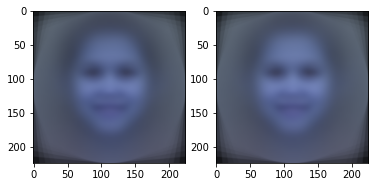

In [8]:


# Generate mean image for each cross validation situation
# eg. When we validate folder 1, RGB mean will be generated from folder 2~5
mean_imgs = []
for i in tqdm.tqdm(range(0, 5)):
    folders = [0,1,2,3,4]
    folders.remove(i)
    mean_image = np.zeros(all_data[0][0].shape)
    n_image = 0
    for folder_index in folders:
        for img in all_data[folder_index]:
            mean_image += img
        n_image += n_images_folders[folder_index]
    mean_imgs.append(np.array(mean_image/n_image, dtype=np.uint8))

print(mean_imgs[0].shape, mean_imgs[1].dtype)
plt.subplot(121),plt.imshow(mean_imgs[0])
plt.subplot(122),plt.imshow(mean_imgs[1])



In [9]:
# Generate h5py dataset
with h5py.File('faces_dataset.h5', 'w') as f:
    for i in range(0, 5):
        dset_face = f.create_dataset("data_"+str(i+1), data = np.array(all_data[i]))
        dset_headers = f.create_dataset('labels_'+str(i+1), data = np.array(all_labels[i]))
    dst_bgr_means = f.create_dataset('bgr_means', data = np.array(bgr_means))
    #dst_mean_imgs = f.create_dataset('mean_imgs', data = np.array(mean_imgs))
print("Generation Success!")

with h5py.File('faces_landmark.h5', 'w') as f:
    for i in range(0, 5):
        dset_landmark = f.create_dataset("landmark_"+str(i+1), data = np.array(all_landmark_points[i]))

Generation Success!
